## Import Libraries and Data

In [87]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import skew

from sklearn.preprocessing import scale

%matplotlib inline

df_train = pd.read_csv("../Sberbank/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("../Sberbank/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("../Sberbank/macro.csv", parse_dates=['timestamp'])
state_build = pd.read_csv('../EDA/merged_w_state_build_2017-05-30.csv')
df_train.head()

# =============================
# =============================
# cleanup
# brings error down a lot by removing extreme price per sqm
print(df_train.shape)
# df_train.loc[df_train.full_sq == 0, 'full_sq'] = 30
print(df_train.shape)
# =============================
# =============================

(30471, 292)
(30471, 292)


In [88]:
frames = [df_train, df_test]

df = pd.concat(frames)

df = df.set_index('id')

In [89]:
df['full_sq^2'] = state_build['full_sq^2']
df['age'] = state_build['age']
df['state'] = state_build['state']

In [90]:
df['age_log'] = np.log1p(df['age'])

## Feature Engineering

In [91]:
# Add month-year
month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df['month'] = df.timestamp.dt.month
df['dow'] = df.timestamp.dt.dayofweek

# Other feature engineering
df['rel_floor'] = df['floor'] / df['max_floor'].astype(float)
df['rel_kitch_sq'] = df['kitch_sq'] / df['full_sq'].astype(float)


# Feature engineering
df['kitch_life'] = df.kitch_sq/df.life_sq
df['extra_on_life'] = df.full_sq/df.life_sq
df['rel_floor'] = df.floor/df.max_floor



# Separate dtypes
df_numeric = df.select_dtypes(exclude=['object', 'datetime'])    
df_obj = df.select_dtypes(include=['object', 'datetime']).copy()


# Deal with categorical values
for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]    # how is this different from above????


# Log transform skewed numeric features 
get_col = df_numeric.dtypes[(df_numeric.dtypes == "int64") | (df_numeric.dtypes == "float64")].index
get_skews = df_numeric[get_col].apply(lambda x: skew(x.dropna()))
get_skews = get_skews[get_skews>0.5]
get_skews = get_skews.index
df_numeric[get_skews] = np.log1p(df_numeric[get_skews])       


# concatenate back    
df = pd.concat([df_numeric, df_obj], axis=1)

In [92]:
# features to not use

not_important = ['timestamp', 'full_sq','max_floor', 'build_year','age', 'price_doc']

In [93]:
for feature in not_important:
    df = df.loc[:, df.columns != feature]

In [94]:
df_values = df

In [95]:
from sklearn import preprocessing

for feature in df_values.columns:
    if df_values[feature].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_values[feature].values)) 
        df_values[feature] = lbl.transform(list(df_values[feature].values))

In [96]:
for feature in df_values.columns:
    if np.sum(df_values[feature].isnull()) > 400:
        df_values = df_values.loc[:, df_values.columns != feature]

In [97]:
for feature in df_values.columns:
    if np.sum(df_values[feature].isnull()) > 0:
        print feature,np.sum(df_values[feature].isnull())

ID_railroad_station_walk 59
floor 167
green_part_2000 19
metro_km_walk 59
metro_min_walk 59
prom_part_5000 270
railroad_station_walk_km 59
railroad_station_walk_min 59


In [98]:
# df = df_values.dropna()

# impute missing values with mean
df_values = df_values.loc[:, df_values.columns != 'price_doc_log'].apply(lambda x: x.fillna(x.median()),axis=0) # newdf is the numeric columns

no null features remaining!

In [99]:
# add back price_doc_log
frames = [df_train, df_test]

df_price = pd.concat(frames)
df_price.shape

(38133, 292)

In [ ]:
df_price['price_doc_log'] = np.log1p(df_price['price_doc'])

In [101]:
df_values['price_doc_log'] = np.log1p(df_price['price_doc']).values

In [102]:
# df_values['price_doc_log'] = np.log1p(df_values['price_doc_log'])
df_values = df_values.drop('price_doc', axis=1)

ValueError: labels ['price_doc'] not contained in axis

In [103]:
df_values.columns

Index([u'0_13_all', u'0_13_female', u'0_13_male', u'0_17_all', u'0_17_female',
       u'0_17_male', u'0_6_all', u'0_6_female', u'0_6_male', u'16_29_all',
       ...
       u'nuclear_reactor_raion', u'oil_chemistry_raion', u'product_type',
       u'radiation_raion', u'railroad_1line', u'railroad_terminal_raion',
       u'sub_area', u'thermal_power_plant_raion', u'water_1line',
       u'price_doc_log'],
      dtype='object', length=249)

In [158]:
df_train = df_values.loc[df_values['price_doc_log'].notnull()]
df_test = df_values.loc[df_values['price_doc_log'].isnull()]

In [159]:
df_train

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,nuclear_reactor_raion,oil_chemistry_raion,product_type,radiation_raion,railroad_1line,railroad_terminal_raion,sub_area,thermal_power_plant_raion,water_1line,price_doc_log
id,,,,,,,,,,,,,,,,,,,,,
1,9.833869,9.098962,9.180912,10.069171,9.334150,9.416297,9.167120,8.450626,8.496990,9.770470,...,0,0,0,0,0,0,0,0,0,15.581952
2,9.527338,8.824825,8.843615,9.781376,9.071423,9.104869,8.836519,8.135933,8.151045,9.626745,...,0,0,0,0,0,0,1,0,0,15.607270
3,9.328390,8.582419,8.685585,9.608109,8.862767,8.964696,8.679312,7.932003,8.037866,9.873131,...,0,0,0,1,0,0,2,0,0,15.555977
4,10.124028,9.405331,9.455871,10.375489,9.651880,9.711964,9.479451,8.770750,8.801770,8.099554,...,0,0,0,0,0,0,3,0,0,16.388123
5,9.361515,8.595820,8.736168,9.631548,8.871365,9.001346,8.649449,7.910224,8.000685,8.549660,...,0,0,0,1,1,1,4,0,0,16.608603
6,8.440960,7.711549,7.783224,8.677099,7.948738,8.018296,7.791110,7.085901,7.110696,8.487146,...,0,0,0,1,0,0,5,1,0,16.023785
7,8.493925,7.774015,7.827241,8.781248,8.060224,8.115521,7.807917,7.105786,7.124478,9.875397,...,0,0,0,0,0,0,6,0,0,15.520259
8,9.833869,9.098962,9.180912,10.069171,9.334150,9.416297,9.167120,8.450626,8.496990,9.770470,...,0,0,0,0,0,0,0,0,0,14.508658
9,9.414913,8.662678,8.777710,9.649305,8.896999,9.012133,8.780787,8.023552,8.148156,9.779227,...,0,0,0,0,0,0,7,0,0,15.483218


In [160]:
split_value = np.log1p(11000000) # determined by normality 

In [161]:
df_train = df_train.loc[df_train['price_doc_log'] < split_value, :]
# df_test_high = df_test.loc[df_train['price_doc_log'] > split_value, :]

In [162]:
y_train = df_train['price_doc_log']
X_train = df_train.loc[df_train['price_doc_log'].notnull(), df_train.columns != 'price_doc_log']
X_test = df_test.loc[df_test['price_doc_log'].isnull(), df_test.columns != 'price_doc_log']

In [163]:
X_train.shape, y_train.shape, X_test.shape

((26701, 248), (26701,), (7662, 248))

In [141]:
df_train = df_train.reset_index()

In [164]:
# Save the column names for features names
df_columns = X_train.columns


# Set the parameters
xgb_params = {
    'eta': 0.02,  
    'max_depth': 6,
    'subsample': 1,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',
    'silent': 1
}

# Train the set against the actual prices and then mak predictions
dtrain = xgb.DMatrix(X_train.values, y_train.values, feature_names=df_columns)
dtest = xgb.DMatrix(X_test.values, feature_names=df_columns)

In [165]:
X_train.head()

,0_13_all,0_13_female,0_13_male,0_17_all,0_17_female,0_17_male,0_6_all,0_6_female,0_6_male,16_29_all,...,incineration_raion,nuclear_reactor_raion,oil_chemistry_raion,product_type,radiation_raion,railroad_1line,railroad_terminal_raion,sub_area,thermal_power_plant_raion,water_1line
id,,,,,,,,,,,,,,,,,,,,,
1,9.833869,9.098962,9.180912,10.069171,9.334150,9.416297,9.167120,8.450626,8.496990,9.770470,...,0,0,0,0,0,0,0,0,0,0
2,9.527338,8.824825,8.843615,9.781376,9.071423,9.104869,8.836519,8.135933,8.151045,9.626745,...,0,0,0,0,0,0,0,1,0,0
3,9.328390,8.582419,8.685585,9.608109,8.862767,8.964696,8.679312,7.932003,8.037866,9.873131,...,0,0,0,0,1,0,0,2,0,0
6,8.440960,7.711549,7.783224,8.677099,7.948738,8.018296,7.791110,7.085901,7.110696,8.487146,...,0,0,0,0,1,0,0,5,1,0
7,8.493925,7.774015,7.827241,8.781248,8.060224,8.115521,7.807917,7.105786,7.124478,9.875397,...,0,0,0,0,0,0,0,6,0,0


[0]	train-rmse:14.6894	test-rmse:14.6894
[1]	train-rmse:14.3959	test-rmse:14.3959
[2]	train-rmse:14.1084	test-rmse:14.1084
[3]	train-rmse:13.8266	test-rmse:13.8266
[4]	train-rmse:13.5505	test-rmse:13.5505
[5]	train-rmse:13.2799	test-rmse:13.2799
[6]	train-rmse:13.0147	test-rmse:13.0147
[7]	train-rmse:12.7549	test-rmse:12.7549
[8]	train-rmse:12.5002	test-rmse:12.5002
[9]	train-rmse:12.2507	test-rmse:12.2507
[10]	train-rmse:12.0061	test-rmse:12.0061
[11]	train-rmse:11.7664	test-rmse:11.7665
[12]	train-rmse:11.5316	test-rmse:11.5316
[13]	train-rmse:11.3014	test-rmse:11.3015
[14]	train-rmse:11.0759	test-rmse:11.0759
[15]	train-rmse:10.8549	test-rmse:10.8549
[16]	train-rmse:10.6383	test-rmse:10.6383
[17]	train-rmse:10.426	test-rmse:10.4261
[18]	train-rmse:10.218	test-rmse:10.2181
[19]	train-rmse:10.0142	test-rmse:10.0142
[20]	train-rmse:9.81446	test-rmse:9.81451
[21]	train-rmse:9.61872	test-rmse:9.6188
[22]	train-rmse:9.42691	test-rmse:9.42698
[23]	train-rmse:9.23895	test-rmse:9.23901
[24]	

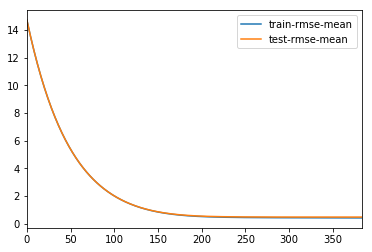

In [166]:
cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=800, early_stopping_rounds=50,
   verbose_eval=True, show_stdv=False)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds = len(cv_result)

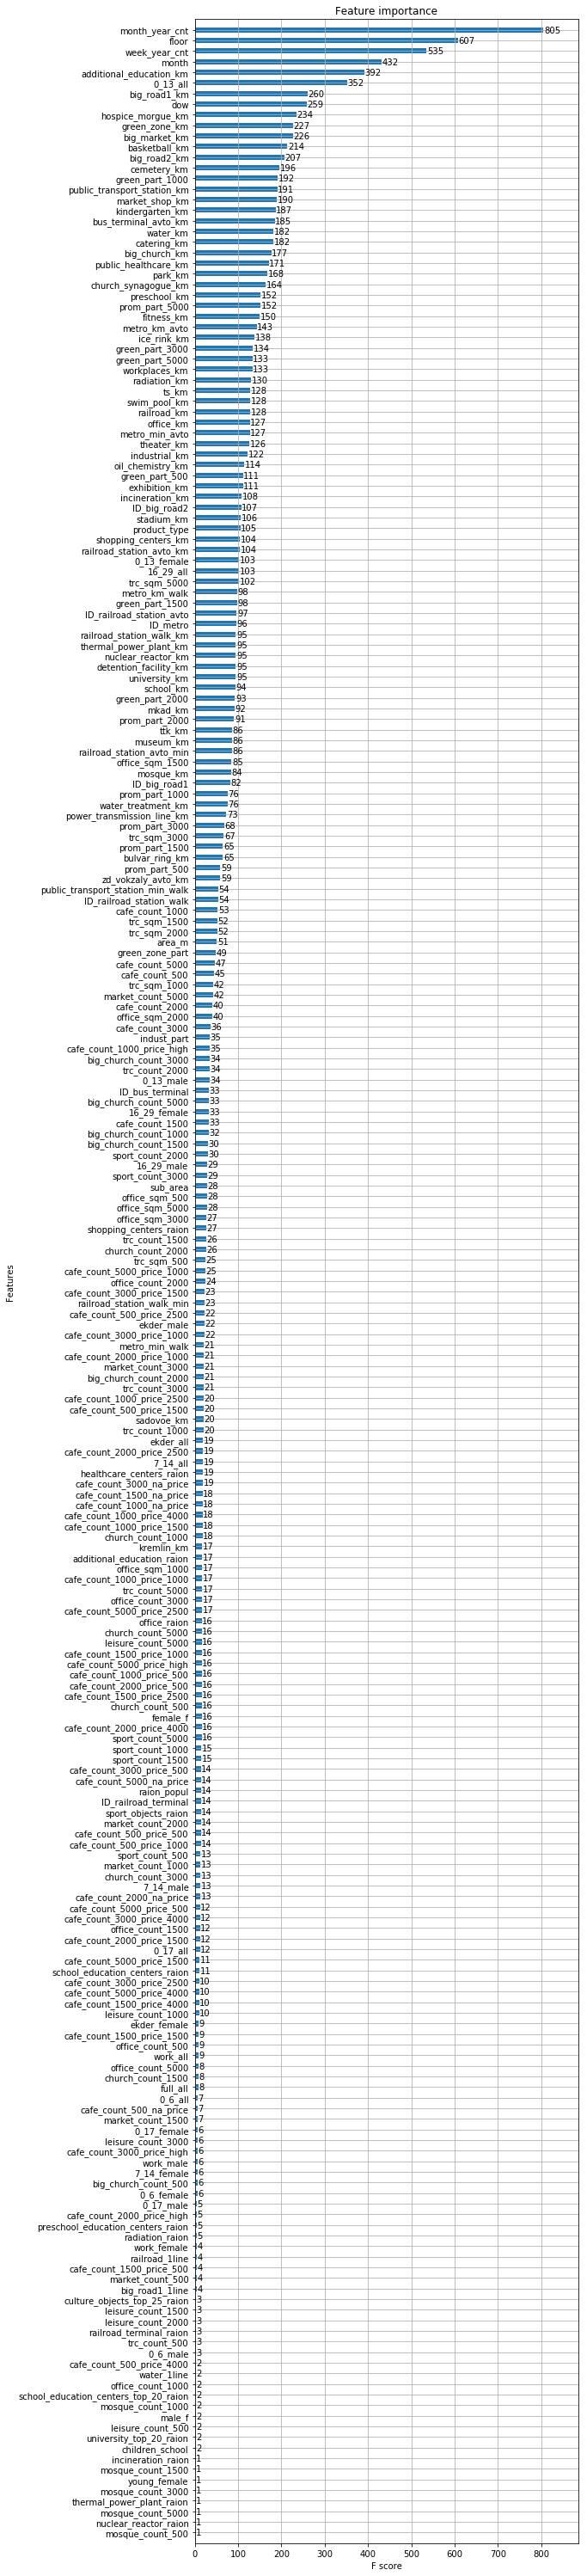

In [167]:
num_boost_rounds = 432

# Tune XGB `num_boost_rounds`

# Run the model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)


# Plot the feature importance
fig, ax = plt.subplots(1, 1, figsize=(8, 54))
xgb.plot_importance(model, height=0.5, ax=ax)


# Make the predictions
y_pred = model.predict(dtest)


# Save the csv
# df_sub.to_csv('sub_param_tuned_3_pradeep.csv', index=False)

In [168]:
sample 

NameError: name 'sample' is not defined

In [169]:
X_test.shape

(7662, 248)

In [170]:
y_test = y_pred

In [171]:
df_test.loc[df_test['price_doc_log'].isnull(),'price_doc_log'] = y_test

In [172]:
y_train = df_train.loc[df_train['price_doc_log'].notnull(), 'price_doc_log']
X_train = df_train.loc[df_train['price_doc_log'].notnull(), df_train.columns != 'price_doc_log']
X_test = df_test.loc[df_test['price_doc_log'].isnull(), df_test.columns != 'price_doc_log']

In [173]:
submission = pd.read_csv('../EDA/submissions/weighted_final_053017.csv', index_col='id')

In [178]:
submission.shape

(7662, 1)

In [175]:
submission['price_doc'] = np.expm1(y_test)

In [126]:
split_value = np.log1p(11000000) # determined by normality 

In [135]:
df_train = df_train.reset_index()

In [136]:
df_train_high = df_train.loc[df_train['price_doc_log'] > split_value, :]
df_test_high = df_test.loc[df_train['price_doc_log'] > split_value, :]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [176]:
submission.to_csv('../EDA/submissions/submission_060117.csv', index=True)

### Split into two regions (by price)

In [126]:
split_value = np.log1p(11000000) # determined by normality 

In [135]:
df_train = df_train.reset_index()

In [136]:
df_train_high = df_train.loc[df_train['price_doc_log'] > split_value, :]
df_test_high = df_test.loc[df_train['price_doc_log'] > split_value, :]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [50]:
y_train_high = df_train_high['price_doc_log']

In [51]:
df_train_low = df_train.loc[df_train['price_doc_log'] < split_value, :]
df_test_low = df_test.loc[df_train['price_doc_log'] < split_value, :]

In [52]:
y_train_low = df_train_low['price_doc_log']

Train a model for high-priced responses (log_price) and low-priced responses (price)

### High Prices (5%)

In [55]:
y_train_high = df_train_high.loc[df_train_high['price_doc_log'].notnull(), 'price_doc_log']
X_train_high = df_train_high.loc[df_train_high['price_doc_log'].notnull(), df_train_high.columns != 'price_doc_log']
X_test_high = df_test_high.loc[df_test_high['price_doc_log'].isnull(), df_test_high.columns != 'price_doc_log']

In [56]:
# Save the column names for features names
df_columns = X_train_high.columns


# Set the parameters
xgb_params = {
    'eta': 0.03,   # 0.05 orig
    'max_depth': 4,    # 5 orig
    'subsample': 0.7,     # 0.7 orig
    'colsample_bytree': 0.7,     # 0.7 orig
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',
    'silent': 1
}

# Train the set against the actual prices and then make predictions
dtrain = xgb.DMatrix(X_train_high.values, y_train_high.values, feature_names=df_columns)
dtest = xgb.DMatrix(X_test_high.values, feature_names=df_columns)

In [57]:
X_train_high.shape, y_train.shape

((3636, 252), (30471,))

[0]	train-rmse:15.5615	test-rmse:15.5615
[1]	train-rmse:15.0951	test-rmse:15.0951
[2]	train-rmse:14.6429	test-rmse:14.6429
[3]	train-rmse:14.204	test-rmse:14.204
[4]	train-rmse:13.7782	test-rmse:13.7782
[5]	train-rmse:13.3654	test-rmse:13.3654
[6]	train-rmse:12.9647	test-rmse:12.9647
[7]	train-rmse:12.5763	test-rmse:12.5763
[8]	train-rmse:12.1994	test-rmse:12.1994
[9]	train-rmse:11.8339	test-rmse:11.8339
[10]	train-rmse:11.4794	test-rmse:11.4794
[11]	train-rmse:11.1355	test-rmse:11.1355
[12]	train-rmse:10.8018	test-rmse:10.8018
[13]	train-rmse:10.4782	test-rmse:10.4782
[14]	train-rmse:10.1643	test-rmse:10.1643
[15]	train-rmse:9.85984	test-rmse:9.85984
[16]	train-rmse:9.56458	test-rmse:9.56458
[17]	train-rmse:9.27815	test-rmse:9.27815
[18]	train-rmse:9.00022	test-rmse:9.00022
[19]	train-rmse:8.73063	test-rmse:8.73063
[20]	train-rmse:8.46913	test-rmse:8.46913
[21]	train-rmse:8.21554	test-rmse:8.21554
[22]	train-rmse:7.96954	test-rmse:7.96954
[23]	train-rmse:7.73098	test-rmse:7.73098
[24]

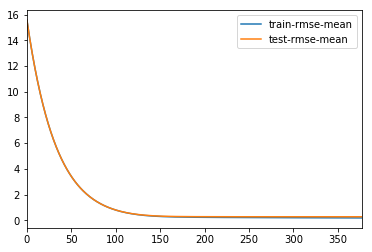

In [58]:
cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
   verbose_eval=True, show_stdv=False)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds = len(cv_result)

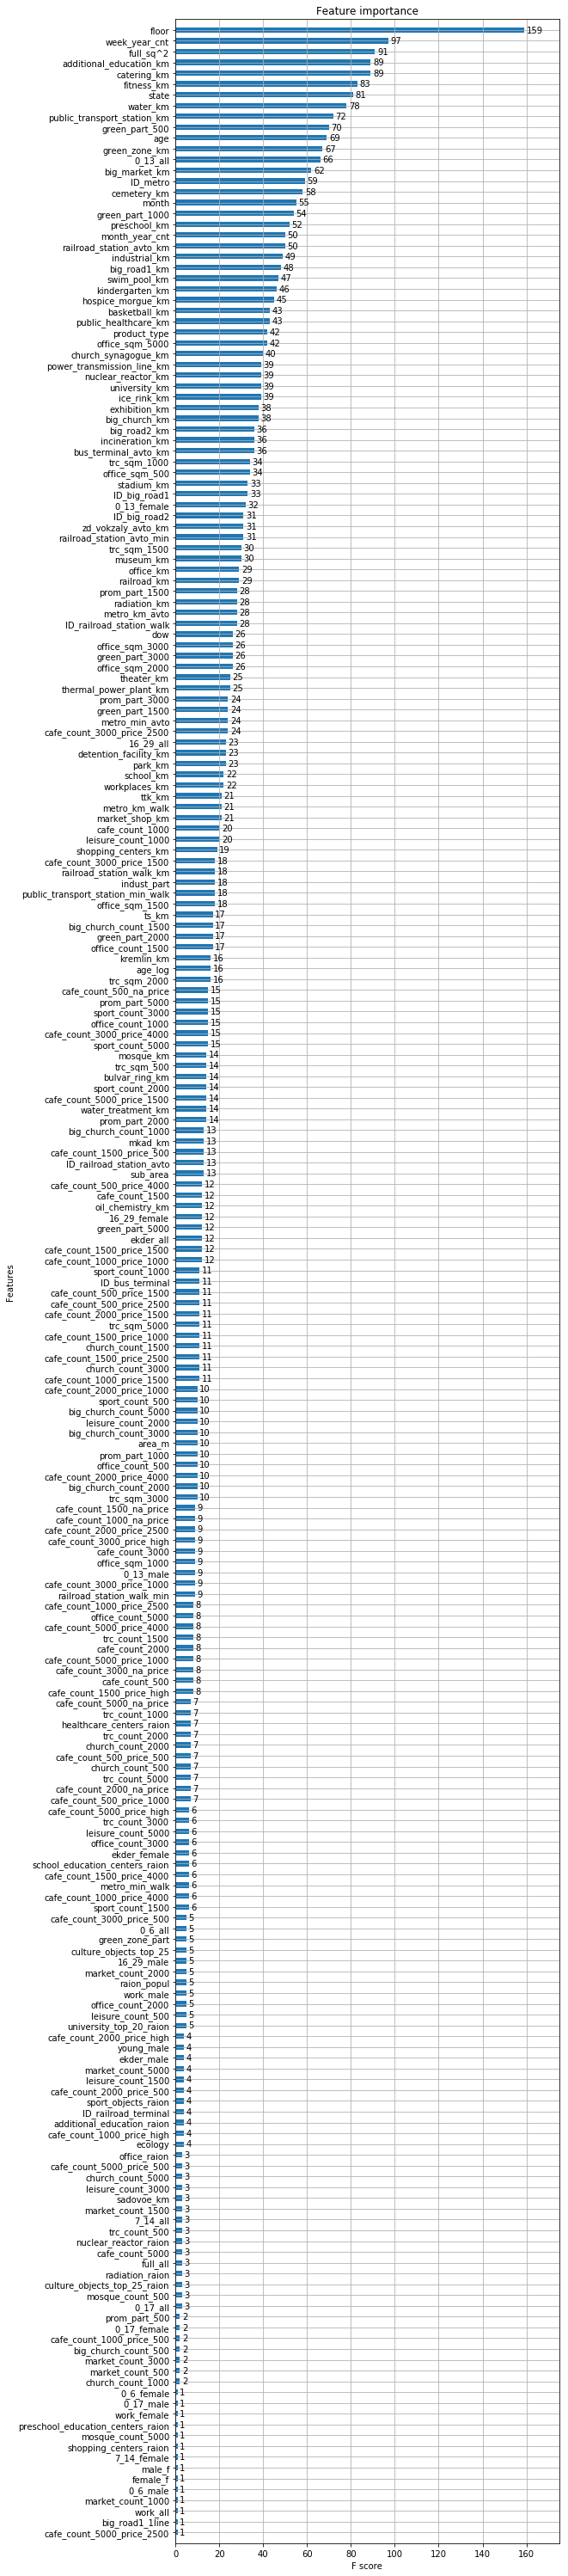

In [59]:
num_boost_rounds = 426

# Tune XGB `num_boost_rounds`

# Run the model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)


# Plot the feature importance
fig, ax = plt.subplots(1, 1, figsize=(8, 54))
xgb.plot_importance(model, height=0.5, ax=ax)


# Make the predictions
y_pred = model.predict(dtest)


# Save the csv
# df_sub.to_csv('sub_param_tuned_3_pradeep.csv', index=False)

In [60]:
y_test_high = y_pred

### Low Prices (95%)

In [61]:
y_train_low = df_train_low.loc[df_train_low['price_doc_log'].notnull(), 'price_doc_log']
X_train_low = df_train_low.loc[df_train_low['price_doc_log'].notnull(), df_train_low.columns != 'price_doc_log']
X_test_low = df_test_low.loc[df_test_low['price_doc_log'].isnull(), df_test_low.columns != 'price_doc_log']

In [62]:
# Save the column names for features names
df_columns = X_train_low.columns


# Set the parameters
xgb_params = {
    'eta': 0.03,   # 0.05 orig
    'max_depth': 4,    # 5 orig
    'subsample': 0.7,     # 0.7 orig
    'colsample_bytree': 0.7,     # 0.7 orig
    'objective': 'reg:linear',    
    'eval_metric': 'rmse',
    'silent': 1
}

# Train the set against the actual prices and then make predictions
dtrain = xgb.DMatrix(X_train_low.values, y_train_low.values, feature_names=df_columns)
dtest = xgb.DMatrix(X_test_low.values, feature_names=df_columns)

In [63]:
X_train_low.shape, y_train.shape

((26701, 252), (30471,))

[0]	train-rmse:14.5396	test-rmse:14.5396
[1]	train-rmse:14.1041	test-rmse:14.1041
[2]	train-rmse:13.6815	test-rmse:13.6815
[3]	train-rmse:13.2717	test-rmse:13.2717
[4]	train-rmse:12.8741	test-rmse:12.8741
[5]	train-rmse:12.4885	test-rmse:12.4885
[6]	train-rmse:12.1146	test-rmse:12.1146
[7]	train-rmse:11.7519	test-rmse:11.7519
[8]	train-rmse:11.4	test-rmse:11.4
[9]	train-rmse:11.0588	test-rmse:11.0588
[10]	train-rmse:10.7277	test-rmse:10.7277
[11]	train-rmse:10.4066	test-rmse:10.4066
[12]	train-rmse:10.0951	test-rmse:10.0951
[13]	train-rmse:9.79306	test-rmse:9.7931
[14]	train-rmse:9.50014	test-rmse:9.50019
[15]	train-rmse:9.216	test-rmse:9.21604
[16]	train-rmse:8.94046	test-rmse:8.9405
[17]	train-rmse:8.67325	test-rmse:8.6733
[18]	train-rmse:8.41395	test-rmse:8.41401
[19]	train-rmse:8.16254	test-rmse:8.16258
[20]	train-rmse:7.91858	test-rmse:7.91865
[21]	train-rmse:7.68219	test-rmse:7.68224
[22]	train-rmse:7.45279	test-rmse:7.45285
[23]	train-rmse:7.2304	test-rmse:7.23047
[24]	train-rms

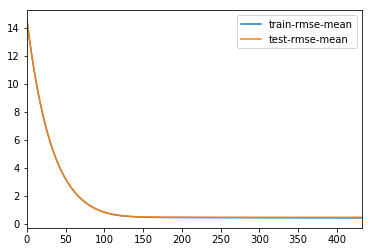

In [64]:
cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=50,
   verbose_eval=True, show_stdv=False)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds = len(cv_result)

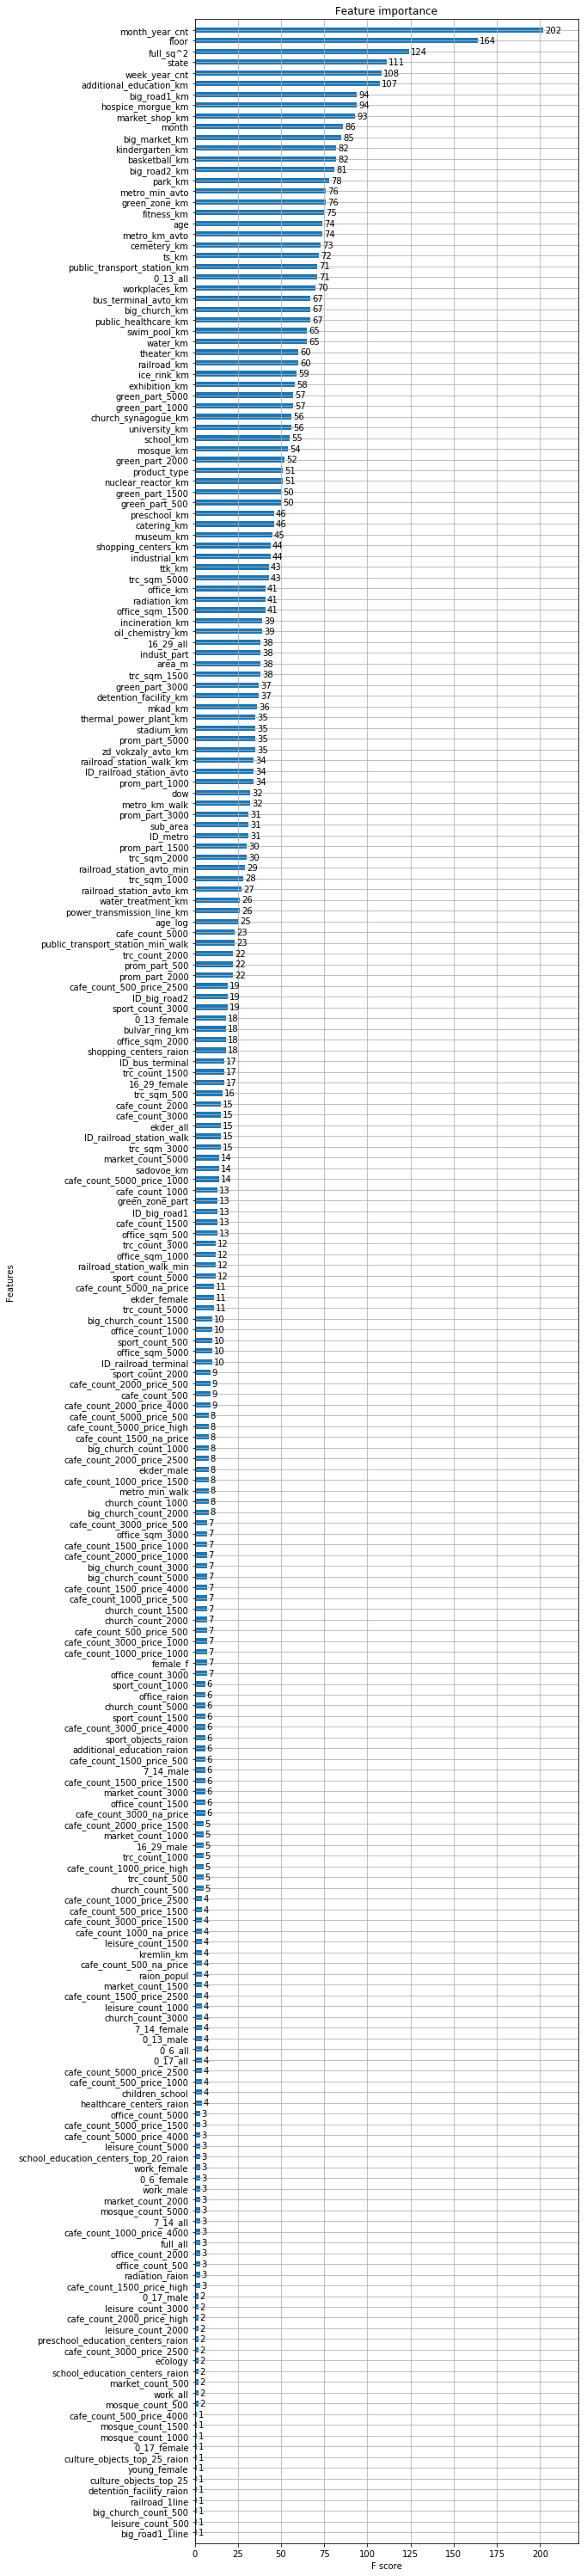

In [65]:
num_boost_rounds = 480

# Tune XGB `num_boost_rounds`

# Run the model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)


# Plot the feature importance
fig, ax = plt.subplots(1, 1, figsize=(8, 54))
xgb.plot_importance(model, height=0.5, ax=ax)


# Make the predictions
y_pred = model.predict(dtest)

In [66]:
y_test_low = y_pred

### Add to low/high datasets

### Merge and submit

In [67]:
len(y_test_high), len(y_test_low),  len(y_test_high) + len(y_test_low)

(659, 6969, 7628)

In [68]:
len(X_test_high), len(X_test_low),  len(X_test_high) + len(X_test_low)

(659, 6969, 7628)

In [69]:
X_test_high['price_doc_log'] = y_test_high
X_test_low['price_doc_log'] = y_test_low

In [70]:
frames = [X_test_low, X_test_high]

X_test = pd.concat(frames)

In [71]:
frames = [X_train_low, X_train_high]

X_train = pd.concat(frames)

In [72]:
frames = [y_train_low, y_train_high]

y_train = pd.concat(frames)

In [76]:
y_pred = X_test['price_doc_log','id']

KeyError: ('price_doc_log', 'id')

In [56]:
sample = pd.read_csv('../EDA/submissions/31310.csv')

In [57]:
sample = sample.merge(y_pred, left_on='id',right_on='id',how='left')

In [58]:
sample.loc[sample['price_doc_log_y'].isnull(), 'price_doc_log_y'] = sample.loc[sample['price_doc_log_y'].isnull(), 'price_doc_log_x']

In [256]:
# sample['price_doc_log'] = (sample['price_doc_log_x'] + sample['price_doc_log_y'])/2

In [60]:
sample

,id,price_doc_x,price_doc_y
0,30474,5434544.0,5624246.50
1,30475,8202008.0,8142149.00
2,30476,5621595.0,5871584.00
3,30477,5791226.0,11773665.00
4,30478,4799440.0,9828750.00
5,30479,9380446.0,8102527.50
6,30480,4157150.0,4726336.00
7,30481,4074462.0,4651758.50
8,30482,4784814.0,4859559.00
9,30483,4695106.0,4626447.00


In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline 



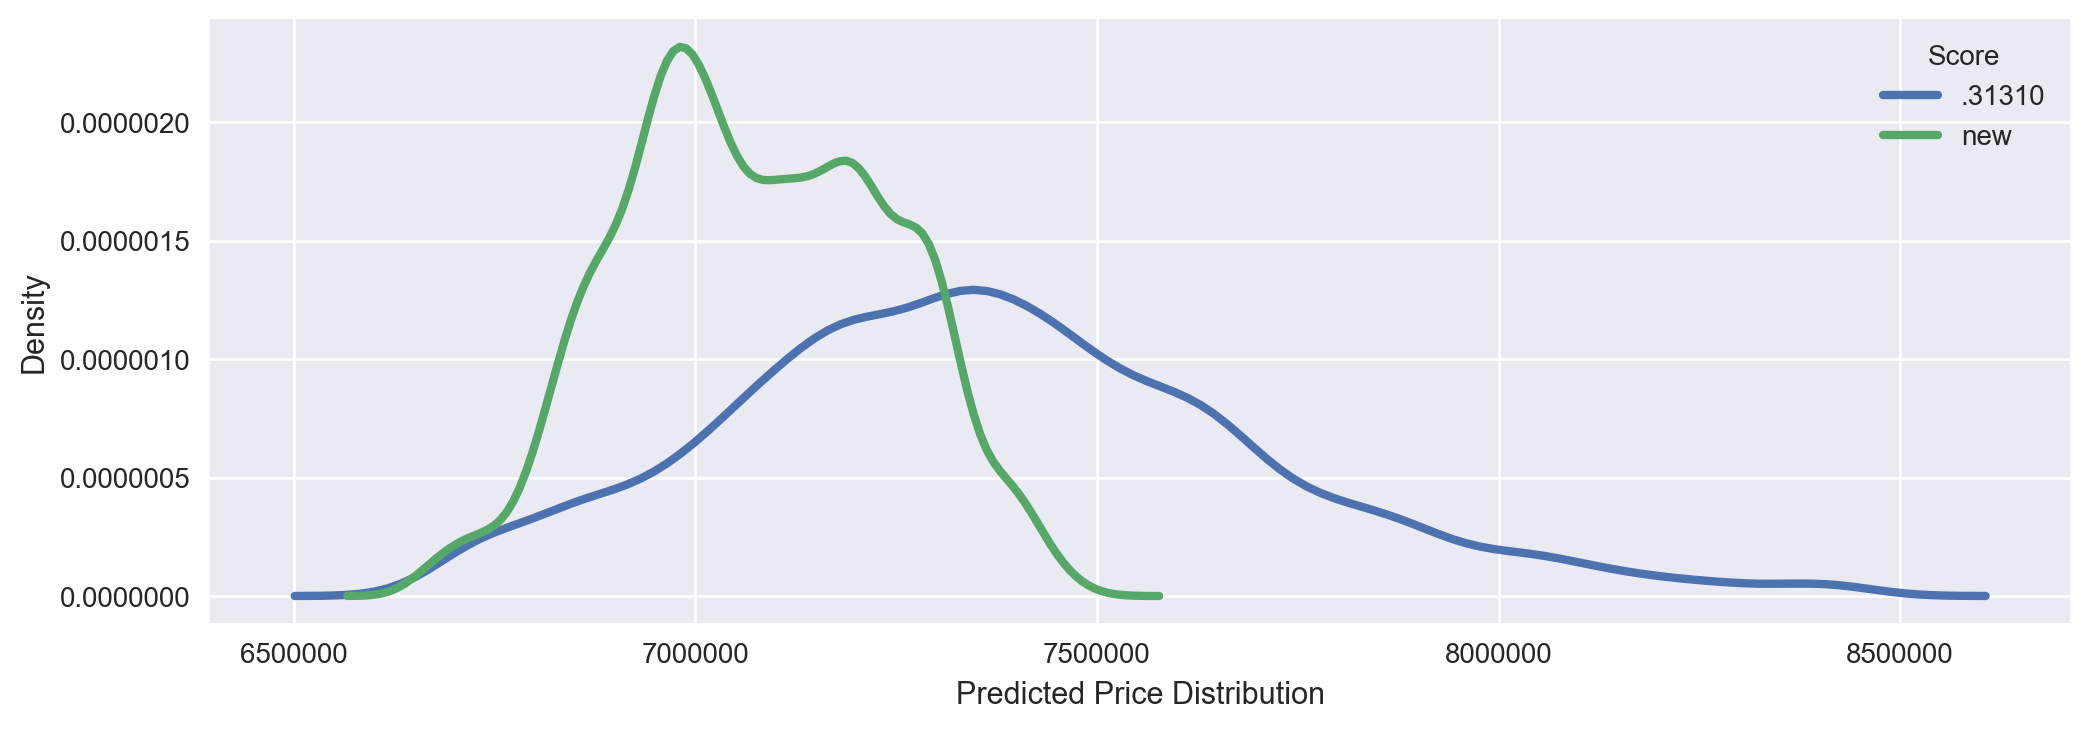

In [63]:
plt.figure(figsize=(12,4),dpi=200)
sns.kdeplot(sample['price_doc_log_x'].rolling(window=300).mean(), label='.31310',lw=3)
sns.kdeplot(sample['price_doc_log_y'].rolling(window=300).mean(), label='new',lw=3)
# sns.kdeplot(sample['price_doc_log'].rolling(window=300).mean(), label='mean',lw=3)
plt.xlabel('Predicted Price Distribution')
plt.ylabel('Density')
plt.legend(title='Score')
plt.show()

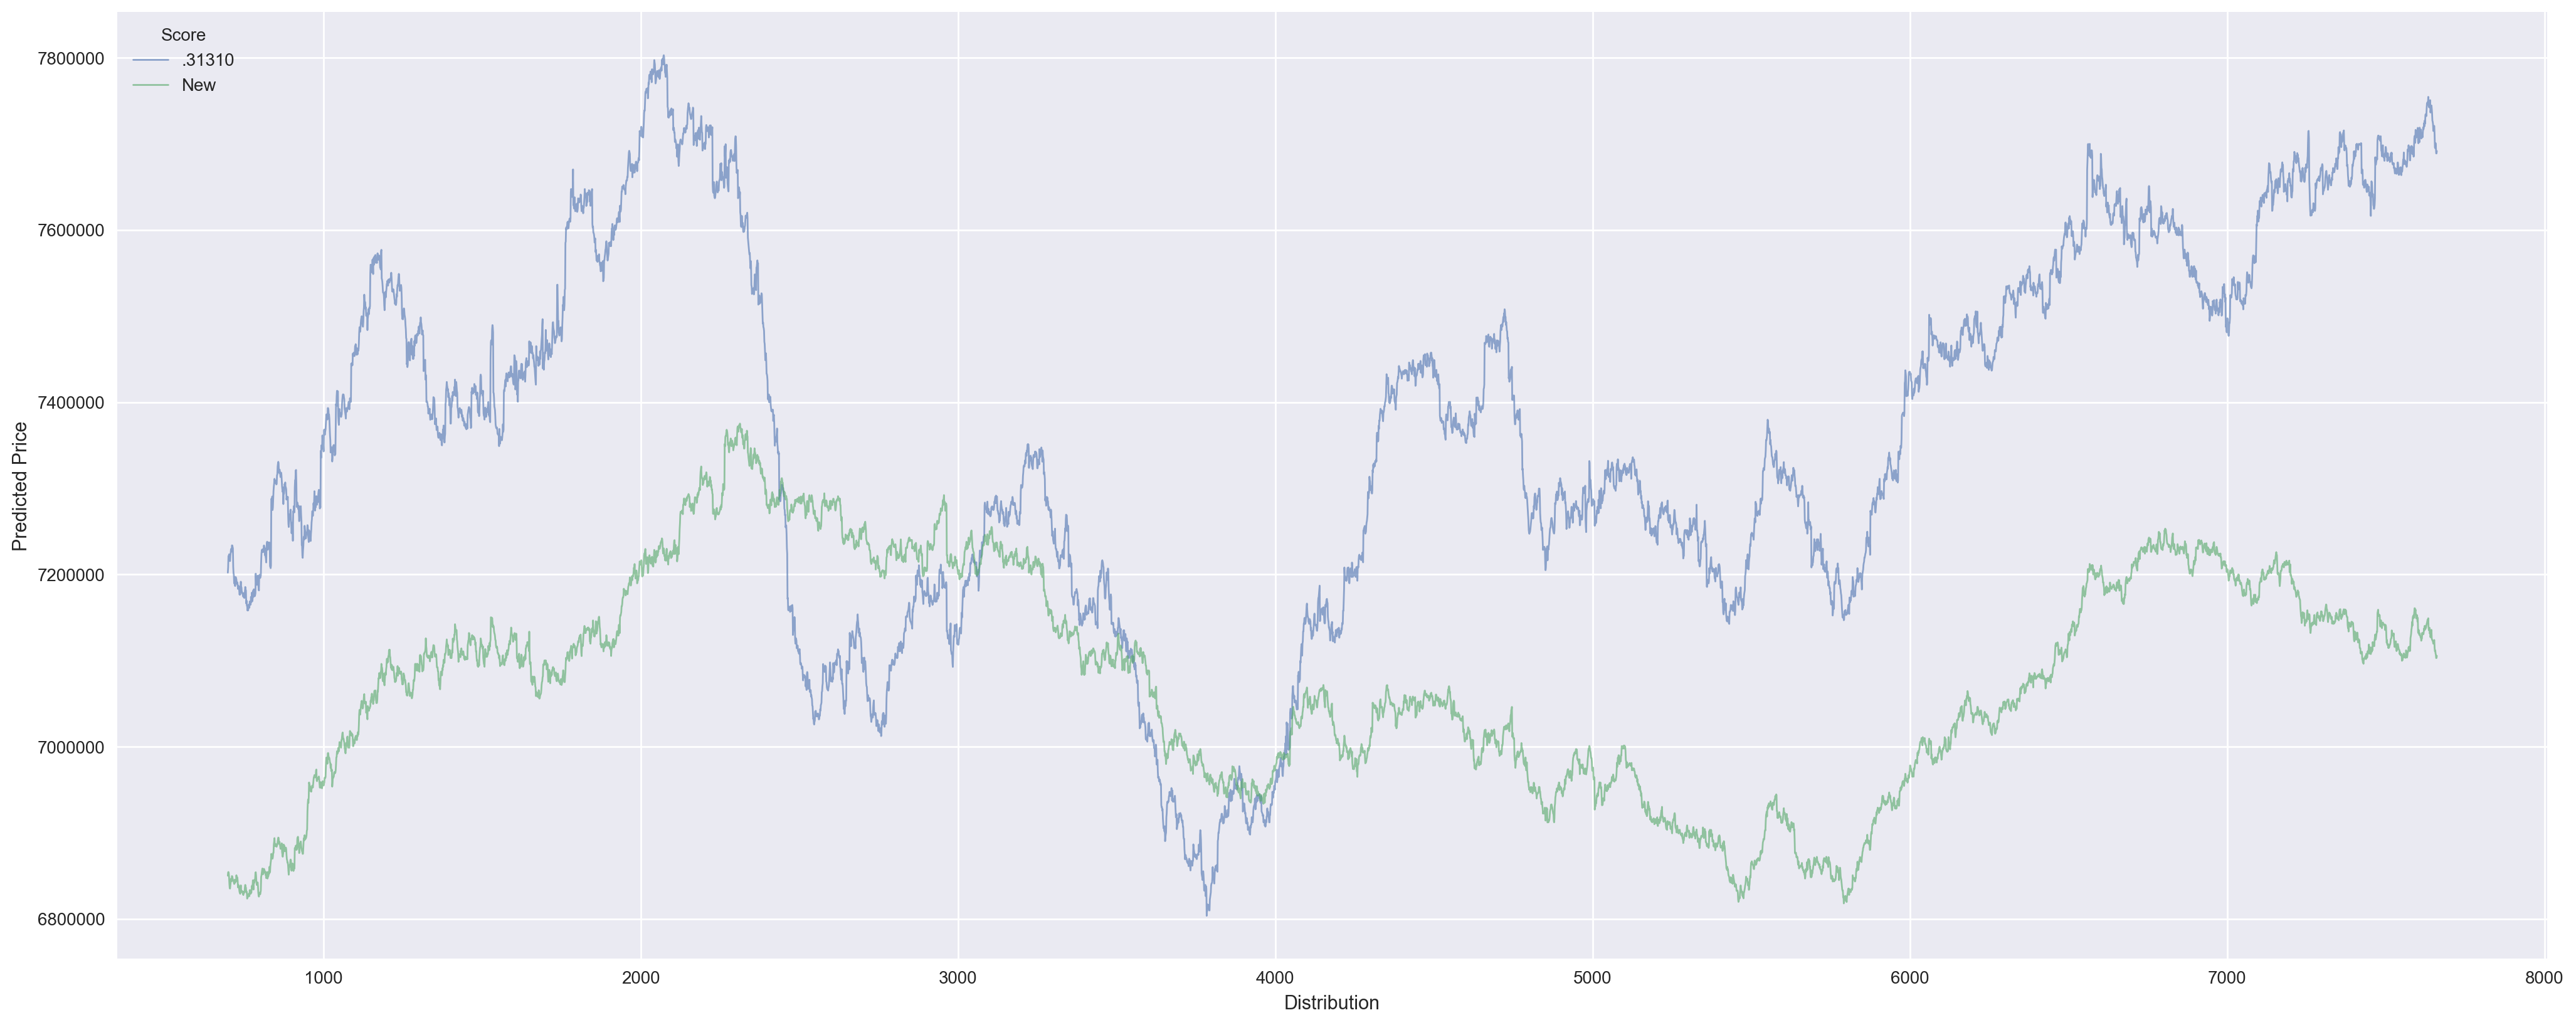

In [65]:
plt.figure(figsize=(25,10),dpi=200)
plt.plot(sample['price_doc_log_x'].rolling(window=700).mean(), label='.31310', alpha =0.6, lw=1)
plt.plot(sample['price_doc_log_y'].rolling(window=700).mean(), label='New', alpha =0.6, lw=1)
# plt.plot(sample['price_doc_log'].rolling(window=700).mean(), label='Mean', alpha =1, lw=2)
plt.xlabel('Distribution')
plt.ylabel('Predicted Price')
plt.legend(title='Score')
plt.show()

In [66]:
submission = sample[['id', 'price_doc_log']]
submission.set_index('id')

KeyError: "['price_doc'] not in index"

In [308]:
submission['price_doc_log'] = submission['price_doc_log']*.97

In [309]:
submission.to_csv('../EDA/submissions/submission_053117.csv')

In [304]:
submission = submission.set_index('id')

In [293]:
submit = pd.read_csv('../EDA/submissions/weighted_final_053017.csv', index_col='id')

In [310]:
submission

,price_doc
id,
30474,5.288503e+06
30475,7.922946e+06
30476,5.280664e+06
30477,9.653219e+06
30478,8.424929e+06
30479,8.389365e+06
30480,4.249527e+06
30481,4.344876e+06
30482,4.732974e+06


In [294]:
submit['price_doc_log'] = sample['price_doc_log']

In [306]:
submission.to_csv('../EDA/submissions/submission_053117.csv', index=True)